In [ ]:
import sys
sys.path.append("../src/")

import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import cv2
from captum.attr import LayerGradCam


from helpers.data_utils import UnlearningDataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATASET = "cifar-100"
UDL = UnlearningDataLoader(
    dataset="cifar-100",
    batch_size=1,
    image_size=32,
    seed=3407,
    is_vit=False,
    is_class_unlearning=False,
    class_to_forget=None,
)
dl, _ = UDL.load_data()
num_classes = len(UDL.classes)
input_channels = UDL.input_channels


AxisError: axis 2 is out of bounds for array of dimension 2

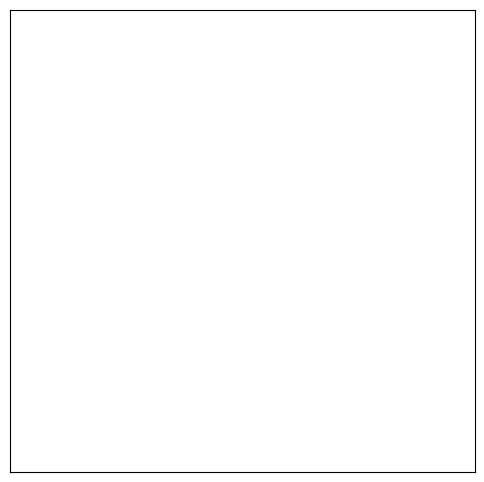

In [ ]:
# Load models
original_model = torch.load("gradcams/models/original-cifar-100-3407.pth")
gold_model = torch.load("gradcams/models/gold-cifar-100-3407.pth")
lotus_model = torch.load("gradcams/models/lotus-cifar-100-3407.pth")

i = 0
for image, label in dl["forget"]:
    image, label = image.to(DEVICE), label.to(DEVICE)
    # Initialize GradCAM
    gradcam_original = GradCAM( model=original_model, target_layers=[original_model.layer4[-1]])
    gradcam_gold = GradCAM(model=gold_model, target_layers=[gold_model.layer4[-1]])
    gradcam_lotus = GradCAM(model=lotus_model, target_layers=[lotus_model.layer4[-1]])

    # Generate heatmaps
    grayscale_cam_original = gradcam_original(input_tensor=image)[0]
    grayscale_cam_gold = gradcam_gold(input_tensor=image)[0]
    grayscale_cam_lotus = gradcam_lotus(input_tensor=image)[0]

    # Convert grayscale CAM to RGB heatmap
    image_np = image.cpu().numpy().squeeze().transpose(1, 2, 0)
    image_np = (image_np - image_np.min()) / (
        image_np.max() - image_np.min()
    )  # Normalize to [0, 1]
    heatmap_original = show_cam_on_image(
        image_np.astype(np.float32),
        grayscale_cam_original,
        use_rgb=True,
        image_weight=0.8,
    )
    heatmap_gold = show_cam_on_image(
        image_np.astype(np.float32), grayscale_cam_gold, use_rgb=True, image_weight=0.7
    )
    heatmap_lotus = show_cam_on_image(
        image_np.astype(np.float32), grayscale_cam_lotus, use_rgb=True, image_weight=0.7
    )

    # Display heatmaps
    plt.figure(figsize=(4, 3.5))
    plt.subplot(1, 3, 1)
    plt.title("Original", fontname="Times New Roman", fontsize=12)
    plt.imshow(heatmap_original, interpolation="bilinear")
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 3, 2)
    plt.title("Gold Std", fontname="Times New Roman", fontsize=12)
    plt.imshow(heatmap_gold, interpolation="bilinear")
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 3, 3)
    plt.title("LoTUS", fontname="Times New Roman", fontsize=12)
    plt.imshow(heatmap_lotus, interpolation="bilinear")
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f"gradcams/plots/cifar-100/{i}.png", dpi=300)
    i += 1
    # plt.show()
    # break